In [1]:
import numpy as np
import sys
import os
sys.path.insert(0,"montepython/likelihoods")
sys.path.insert(1,"montepython")

In [2]:

from scipy.interpolate import CubicSpline

In [3]:
import Lya_DESI
from Lya_DESI.emulator_Nyx import Emulator_Nyx



In [4]:

emu_new_lP = Emulator_Nyx.load("/pscratch/sd/n/nilsor/Lya_emu_lambda_P.npz")
#emu_new = Emulator_Nyx.load(os.path.join("data/Lya_DESI","Lya_emu.npz"))
#emu_old = Emulator_Nyx.load(os.path.join("data/Lya_DESI","Lya_emu_old_Sept_2022.hdf5"))
#emus = {'lP':emu_new_lP,'new':emu_new}
#cmaptype = {'lP':'Greens','new':'Reds'}

Building emulator_Nyx.py


In [6]:
print(emu_new_lP.bounds[0])

{'A_lya': [5.657146889990802, 12.342852758186542], 'n_lya': [-2.47142933875679, -2.2485707267925283], 'Fbar': [0.6834886866666666, 0.9728143866666668], 'T_0': [3668.379, 27796.6667], 'gamma': [1.0075, 1.8925], 'lambda_P': [62.00867256593638, 93.49766996079825], 'H_0': [60.778571428571425, 74.1], 'omega_m': [0.11971144996, 0.1589342857142857]}


In [5]:
print([emu_new_lP.bounds[x]['lambda_P'] for x in range(len(emu_new_lP.bounds))])

[[62.00867256593638, 93.49766996079825], [62.62817287959965, 94.65669430109273], [63.23277843461321, 95.42739027043643], [65.92446745332907, 95.58444676939024], [66.68885024735481, 95.92997319515624], [67.19842520874657, 94.62920150337504], [67.35708490636304, 93.37178238567155], [66.83746543661084, 91.5885931589257], [66.7651087754374, 89.31825297273141], [65.82269459569895, 86.24655602418282], [62.8366794883343, 83.19200055455242], [61.27173307324429, 79.22624730383004], [59.876905639784596, 75.81160382234951]]


In [12]:
emu_l1os = {}
for i in range(0,18):
    emu_l1os[i] = Emulator_Nyx.load("/pscratch/sd/n/nilsor/Lya_emu_l1o_lP_{}.npz".format(i))

Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py
Building emulator_Nyx.py


In [13]:
print(emu_l1os[2]==emu_l1os[1])


False


In [14]:
for i in range(12):
    print(np.all(emu_l1os[i].bounds==emu_l1os[i+1].bounds))

False
False
False
False
False
False
False
False
False
False
False
False


In [15]:

from scipy.interpolate import interp1d as interp_lin
def interp_log(x,y,newx):
  return np.exp(interp_lin(np.log(x),np.log(y))(np.log(newx)))
import matplotlib.pyplot as plt

In [16]:
#data_filename = "pk_1d_taylor_bestguess_mock.out"#"pk_1d_DR12_13bins.out"
datafile = open(os.path.join("data/Lya_DESI","pk_1d_Nyx_emu_fiducial_mock.out"),'r')
# Declare vectors and matrices for actual data file
nup = 13*35
Nzbin = 13
Nkperbin = 35
data_z          = np.ndarray(nup,'float')            # data z values
data_k          = np.ndarray(nup,'float')            # data k values
data_pk         = np.ndarray(nup,'float')            # data Pk values
data_spk        = np.ndarray(nup,'float')            # data sPk values
data_noise_pk   = np.ndarray(nup,'float')            # data nPk values
for i in range(nup):
  line = datafile.readline()
  values = [float(valstring) for valstring in line.split()]

  # Each column contains z, k, Pk, sPk, nPk, bPk, tPk
  z,k,Pk,sPk,nPk,bPk,tPk = values
  data_z[i]        = z
  data_k[i]        = k
  data_pk[i]       = Pk
  data_spk[i]      = np.sqrt(sPk*sPk+tPk*tPk) # sigma_stat^2 + sigma_sys^2
  data_noise_pk[i] = nPk
data_z = sorted(list(set(data_z)))
data_k = data_k.reshape(Nzbin,Nkperbin)
data_noise_pk = data_noise_pk.reshape(Nzbin,Nkperbin)
data_pk = data_pk.reshape(Nzbin,Nkperbin)
#data_pk[~self.zmask] = 0.
datafile.close()


In [17]:
print(data_z)

[2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6]


## First order of business: Cross-check with the models.hdf5 file

In [18]:
from scipy.interpolate import interp1d as interp_lin
# Different interpolation methods that can be used on the final emulator outputs
def interp_log(x,y,newx):
    return np.exp(interp_lin(np.log(x),np.log(y))(np.log(newx)))

In [19]:
import h5py

models = h5py.File(os.path.join("data/Lya_DESI","models.hdf5"))

In [20]:
# THIS CAUSES A BUG!!! (hence commented out)
snapnames_old = [x for x in list(models.keys()) if 'cosmo_grid' in x and 'rescale_Fbar_fiducial' in models[x]['redshift_3.2'].keys()]
snapnames = [s for s in ['cosmo_grid_{}'.format(i) for i in range(20)] if s in snapnames_old]

In [21]:
print(snapnames)

['cosmo_grid_0', 'cosmo_grid_1', 'cosmo_grid_2', 'cosmo_grid_3', 'cosmo_grid_4', 'cosmo_grid_5', 'cosmo_grid_6', 'cosmo_grid_7', 'cosmo_grid_8', 'cosmo_grid_9', 'cosmo_grid_10', 'cosmo_grid_11', 'cosmo_grid_12']


In [22]:
print(list(models.keys()))

['bar_ic_grid_3', 'cosmo_grid_0', 'cosmo_grid_1', 'cosmo_grid_10', 'cosmo_grid_11', 'cosmo_grid_12', 'cosmo_grid_13', 'cosmo_grid_14', 'cosmo_grid_15', 'cosmo_grid_16', 'cosmo_grid_17', 'cosmo_grid_2', 'cosmo_grid_3', 'cosmo_grid_4', 'cosmo_grid_5', 'cosmo_grid_6', 'cosmo_grid_7', 'cosmo_grid_8', 'cosmo_grid_9', 'fiducial', 'wdm_3.5kev_grid_1']


In [23]:
k_common = np.array(emu_new.get_karr(2.2))

In [33]:
def extract_snapshot(name):
    cosmopars = dict(models[name].attrs)
    print("Selected a model with H_0 = {}, Omega_m = {} ".format(cosmopars['H_0'],cosmopars['Omega_m']))
    zs_model = [float(x.split('_')[1]) for x in list(models[name].keys())]
    zpars = np.empty(len(data_z),dtype='object')
    k_sim_z = np.empty(len(data_z),dtype='object')
    Pk_sim_z = np.empty(len(data_z),dtype='object')
    facs = np.empty(len(data_z),dtype='object')
    thpars = np.empty(len(data_z),dtype='object')
    for iz,z_sim_z in enumerate(data_z):
        zpars[iz] = (dict(models[name]['redshift_{}'.format(z_sim_z)].attrs))
        thpars[iz] = (dict(models[name]['redshift_{}'.format(z_sim_z)]['rescale_Fbar_fiducial'].attrs))
        k_sim_z[iz] = models[name]['redshift_{}'.format(z_sim_z)]['rescale_Fbar_fiducial']['1d power']['k']
        Pk_sim_z[iz] = models[name]['redshift_{}'.format(z_sim_z)]['rescale_Fbar_fiducial']['1d power']['Pk1d']
        facs[iz] = (cosmopars['H_0']*np.sqrt(cosmopars['Omega_m']*(1.+z_sim_z)**3+(1-cosmopars['Omega_m']))/(1.+z_sim_z))
    zpars = np.array(zpars)
    thpars = np.array(thpars)
    k_sim_z = np.array([x for x in k_sim_z])
    Pk_sim_z = np.array([x for x in Pk_sim_z])
    facs = np.array(facs)
    return cosmopars, thpars, zpars, k_sim_z, Pk_sim_z, facs

In [36]:

def evaluate_at_snapshot(i,units="skm"):
    snapname = snapnames[i]
    print("Trying to open name == ",snapname)
    cosmopars, thpars, zpars, k_sim_z, Pk_sim_z, facs = extract_snapshot(snapname)
    pk_truths = np.empty(len(data_z),dtype=object)
    pk_predictions = np.empty(len(data_z),dtype=object)
    pk_predictions_l1o = np.empty(len(data_z),dtype=object)
    in_bounds = np.empty(len(data_z),dtype=bool)
    for iz,z in enumerate(data_z):
        pk_pred = emu_new_lP({'A_lya':cosmopars['A_lya'],'n_lya':cosmopars['n_lya'],'Fbar':thpars[iz]['Fbar'],'T_0':thpars[iz]['T_0'],'gamma':thpars[iz]['gamma'],'lambda_P':zpars[iz]['lambda_P'],'H_0':cosmopars['H_0'],'omega_m':cosmopars['omega_m']},data_z[iz])[0]
        k_pred = emu_new_lP.get_karr(data_z[iz])
        pk_pred_l1o = emu_l1os[i]({'A_lya':cosmopars['A_lya'],'n_lya':cosmopars['n_lya'],'Fbar':thpars[iz]['Fbar'],'T_0':thpars[iz]['T_0'],'gamma':thpars[iz]['gamma'],'lambda_P':zpars[iz]['lambda_P'],'H_0':cosmopars['H_0'],'omega_m':cosmopars['omega_m']},data_z[iz])[0]
        k_pred_l1o = emu_l1os[i].get_karr(data_z[iz])
        in_bounds[iz] = True
        try:
            emu_l1os[i].in_bounds({'A_lya':cosmopars['A_lya'],'n_lya':cosmopars['n_lya'],'Fbar':thpars[iz]['Fbar'],'T_0':thpars[iz]['T_0'],'gamma':thpars[iz]['gamma'],'lambda_P':zpars[iz]['lambda_P'],'H_0':cosmopars['H_0'],'omega_m':cosmopars['omega_m']},data_z[iz])
        except Exception as e:
            in_bounds[iz] = False
            print(e)
        if units=="skm":
            pk_truths[iz] = interp_log(k_sim_z[iz]/facs[iz],Pk_sim_z[iz]*facs[iz],data_k[iz])
            pk_predictions[iz] = interp_log(k_pred/facs[iz],pk_pred*facs[iz],data_k[iz])
            pk_predictions_l1o[iz] = interp_log(k_pred_l1o/facs[iz],pk_pred_l1o*facs[iz],data_k[iz])
        else:
            pk_truths[iz] = interp_log(k_sim_z[iz],Pk_sim_z[iz],k_common*1.0000001)
            if len(k_pred)!=len(k_common) or np.any(np.abs(np.array(k_pred)/np.array(k_common)-1.)>0.01):
                pk_predictions[iz] = interp_log(k_pred,pk_pred,k_common)
                pk_predictions_l1o[iz] = interp_log(k_pred_l1o,pk_pred_l1o,k_common)
            else:
                pk_predictions[iz] = pk_pred
                pk_predictions_l1o[iz] = pk_pred_l1o
    return pk_predictions, pk_predictions_l1o, pk_truths, in_bounds

In [37]:
pk_pred, pk_pred_l1o, pk_true, in_bounds = evaluate_at_snapshot(0)
print("in_bounds = {}".format(in_bounds))

Trying to open name ==  cosmo_grid_0
Selected a model with H_0 = 64.60714285714286, Omega_m = 0.36314563782035697 
in_bounds = [ True  True  True  True  True  True  True  True  True  True  True  True
  True]


In [38]:
print(snapnames)

['cosmo_grid_0', 'cosmo_grid_1', 'cosmo_grid_2', 'cosmo_grid_3', 'cosmo_grid_4', 'cosmo_grid_5', 'cosmo_grid_6', 'cosmo_grid_7', 'cosmo_grid_8', 'cosmo_grid_9', 'cosmo_grid_10', 'cosmo_grid_11', 'cosmo_grid_12']


Trying to open name ==  cosmo_grid_0
Selected a model with H_0 = 64.60714285714286, Omega_m = 0.36314563782035697 
0 True True (array([], dtype=int64),)
Trying to open name ==  cosmo_grid_1
Selected a model with H_0 = 70.35000000000001, Omega_m = 0.3211362937859906 
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=2.2
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=2.4
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=2.6
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=2.8
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=3.0
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=3.2
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=3.4
Parameter omega_m=0.1589342857142857 is 

Text(0.0, 0.5, 'P(k) percentage error [%]')

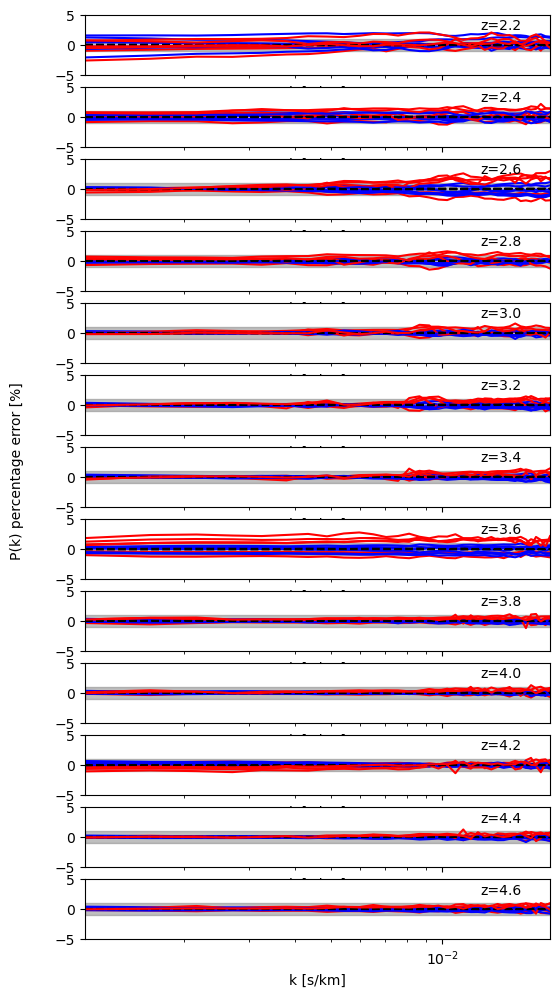

In [39]:
fig, axs = plt.subplots(len(data_z),figsize=(6,12),sharex=True)
for i in range(len(snapnames)):
    pk_pred, pk_pred_l1o, pk_true, in_bounds = evaluate_at_snapshot(i)
    print(i, np.any(in_bounds), np.all(in_bounds), np.where(~in_bounds))
    for iz,z in enumerate(data_z):
        axs[iz].semilogx(data_k[iz],data_k[iz]*0.,linestyle="--",color="black")
        #axs[iz].semilogx(data_k[iz],100.*(pk_pred_l1o[iz]/pk_true[iz]-1),color=plt.get_cmap("gist_rainbow")(i/13.))
        axs[iz].semilogx(data_k[iz],100.*(pk_pred_l1o[iz]/pk_true[iz]-1),color=("blue" if in_bounds[iz] else "red"))
        axs[iz].set_xlim(np.min(data_k[iz]),np.max(data_k[iz]))
for iz,z in enumerate(data_z):
    axs[iz].set_ylim(-5,5)
    axs[iz].set_xlabel("k [s/km]")
    axs[iz].axhspan(-1,1.,color="grey",alpha=0.5)
    axs[iz].text(0.85,0.75,"z={}".format(z),transform=axs[iz].transAxes)
fig.text(0.00, 0.5, "P(k) percentage error [%]", va='center', rotation='vertical')


Trying to open name ==  cosmo_grid_0
Selected a model with H_0 = 64.60714285714286, Omega_m = 0.36314563782035697 
Trying to open name ==  cosmo_grid_1
Selected a model with H_0 = 70.35000000000001, Omega_m = 0.3211362937859906 
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=2.2
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=2.4
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=2.6
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=2.8
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=3.0
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=3.2
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.15648285714285712] -- z=3.4
Parameter omega_m=0.1589342857142857 is not in bounds [0.11971144996,0.1564828

Text(0.0, 0.5, 'P(k) percentage error [%]')

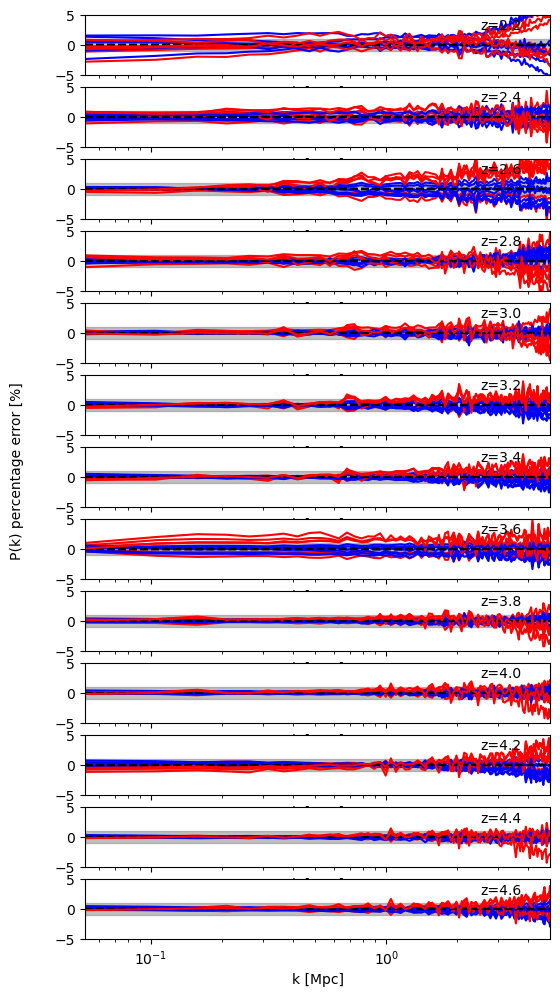

In [41]:
fig, axs = plt.subplots(len(data_z),figsize=(6,12),sharex=True)
for i in range(len(snapnames)):
    pk_pred, pk_pred_l1o, pk_true, in_bounds = evaluate_at_snapshot(i,units="Mpc")
    for iz,z in enumerate(data_z):
        axs[iz].semilogx(k_common,k_common*0.,linestyle="--",color="black")
        #axs[iz].semilogx(k_common,100.*(pk_pred_l1o[iz]/pk_true[iz]-1),color=plt.get_cmap("gist_rainbow")(i/13.))
        axs[iz].semilogx(k_common,100.*(pk_pred_l1o[iz]/pk_true[iz]-1),color=("blue" if in_bounds[iz] else "red"))
        axs[iz].set_xlim(np.min(k_common),np.max(k_common))
for iz,z in enumerate(data_z):
    axs[iz].set_ylim(-5,5)
    axs[iz].set_xlabel("k [Mpc]")
    axs[iz].axhspan(-1,1.,color="grey",alpha=0.5)
    axs[iz].text(0.85,0.75,"z={}".format(z),transform=axs[iz].transAxes)
fig.text(0.00, 0.5, "P(k) percentage error [%]", va='center', rotation='vertical')
